# Convolutional Neural Network (CNN) for Fruit-Image Classification

In [15]:
import numpy as np

from keras.datasets import cifar100
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

Für unser Modell nutzen wir den CIFAR100-Datensatz, der über das Modul *keras.datasets* zur Verfügung steht. Dieser besteht aus insgesamt **60000 farbigen Bildern** aufgeteilt in **50000 Trainingsbilder** und **10000 Testbildern**. Die Bilder haben jeweils eine Auflösung von **32x32 Pixeln** und können folgendermaßen geladen werden:

In [16]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

Trainings- und Testdaten können über *cifar100.load_data()* geladen werden. Der Datensatz setzt sich aus Kategorien samt Subkategorien zusammen. Über das Argument *label_mode* fordern wir alle Subkategorien an. Da wir mit unserem Modell nur **Früchte** klassizieren möchten, reduzieren wir unsere Daten auf die Kategorien: **Apple, Orange, Pear**. Diese Klassen entsprechen den Labels mit der ID: Apple = 0, Orange = 53, Pear = 57.

In [17]:
indices_train, indices_test = [], []

# Wir untersuchen, ob es sich bei einem Eintrag der Trainings-Labels um eines der Früchte handelt.
# Falls ja, fügen wir dessen Index einem zuvor initialisiertem Array hinzu.
for i in range(len(y_train)):
    if y_train[i] == 0 or y_train[i] == 53 or y_train[i] == 57:
        indices_train.append(i)

# Selbiges führen wir für alle Test-Labels durch.
for i in range(len(y_test)):
    if y_test[i] == 0 or y_test[i] == 53 or y_test[i] == 57:
        indices_test.append(i)

# Wir reduzieren unsere Trainings- und Test-Labels auf alle die, der Früchte.
y_train = np.array(y_train[indices_train])
y_test = np.array(y_test[indices_test])

# Wir reduzieren unsere Trainings- und Testdaten auf alle die, der Früchte.
x_train = x_train[np.ravel(indices_train)]
x_test = x_test[np.ravel(indices_test)]

# Für die Konvertierung unserer Label-Vektoren in Binäre-Klassenmatrizen, ändern wir alle ursprünglichen
# Trainings- und Test-Labels in die Werte 0-2. Man beachte: range(start, ende) inkludiert ende nicht!
for i in range(len(y_train)):
    if y_train[i] == 0:
        np.put(y_train, i, 0)
    elif y_train[i] == 53:
        np.put(y_train, i, 1)
    elif y_train[i] == 57:
        np.put(y_train, i, 2)

for i in range(len(y_test)):
    if y_test[i] == 0:
        np.put(y_test, i, 0)
    elif y_test[i] == 53:
        np.put(y_test, i, 1)
    elif y_test[i] == 57:
        np.put(y_test, i, 2)


# Die Konvertierung unser Label-Vektoren in Binäre-Klassenmatrizen wird für unseren Datensatz benötigt.
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

Zur Verifizierung der Daten können wir ein paar Beispiele mit Hilfe des Moduls **matplotlib** plotten.

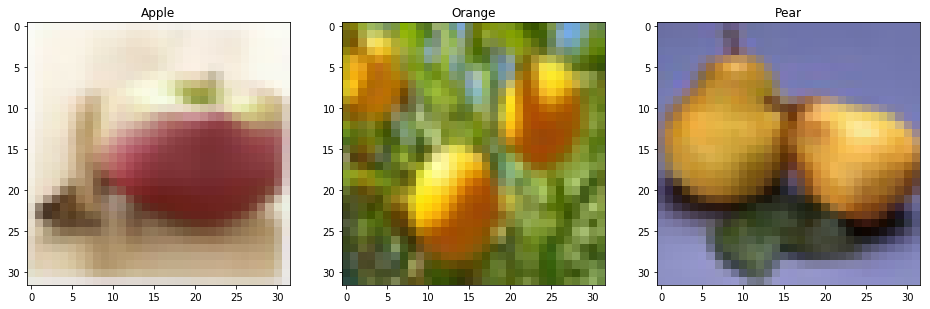

In [18]:
# Dafür plotten wir jeweils 1 Bild der drei Kategorien.
fig = plt.figure(figsize=(16, 6))

apple = fig.add_subplot(1, 3, 1)
apple.set_title("Apple")
apple.imshow(x_train[0])

orange = fig.add_subplot(1, 3, 2)
orange.set_title("Orange")
orange.imshow(x_train[1])

pear = fig.add_subplot(1, 3, 3)
pear.set_title("Pear")
pear.imshow(x_train[6])

plt.show()

Eine Normalisierung der Daten liefert uns eine

In [19]:
# Wir müssen zuvor unsere Bilddaten in Float-Datentypen casten, dass wir Gleitkommazahlen bekommen. 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Konvertieren der RGB-Werte in Werte zwischen [0;1]
x_train /= 255
x_test /= 255

Im folgenden Schritt definieren wir unser Modell. Wir nutzen für die Klassifizierung unserer Bilder ein **Convolutional Neural Network (CNN)**. Das Modell besteht aus vier *Convolutional Layern* und drei *Pooling Layern*. Unsere Filtergröße beträgt *3 x 3*. Wir verwenden für jede Schicht die *ReĹu*-Aktivierungsfunktion. Nur unser Ausgabeschicht verwendet eine *Softmax*-Aktivierungsfunktionen. Als Error-Funktion kommt für Multiklassifizierung bestimmte *Categorial_Crossentropy*  zum Einsatz. Als Optimierer benutzen wir den stochastischen Optimierer *Adam*.

In [20]:
# Wir definieren unser Model über einen Stapel von Schichten. Hierzu initialisieren wir unser sequentialles Modell.
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(96, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(192, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Dropout(0.4))
model.add(Flatten())

model.add(Dense(96, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

Zum Trainieren des Modells übergeben wir der **fit()**-Methode unsere Trainingsdaten und -Labels. Das Modell wird über 5 Epochen trainiert. Wir verwenden unsere Testdaten und -Labels zur Validierung unseres Modells nach jeder Epoche über das Argument *validation_data*. "Loss" und "Accuracy" werden standardmäßig nach jeder Epoche und nach dem Trainieren ausgegeben (verbose default: 1).

In [21]:
model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

Train on 1500 samples, validate on 300 samples
Epoch 1/20
1500/1500 [==============================] - 2s 2ms/step - loss: 0.9480 - acc: 0.5413 - val_loss: 0.6805 - val_acc: 0.7567
Epoch 2/20
1500/1500 [==============================] - 2s 1ms/step - loss: 0.7498 - acc: 0.6873 - val_loss: 0.5907 - val_acc: 0.7633
Epoch 3/20
1500/1500 [==============================] - 2s 1ms/step - loss: 0.6150 - acc: 0.7313 - val_loss: 0.5141 - val_acc: 0.7767
Epoch 4/20
1500/1500 [==============================] - 2s 1ms/step - loss: 0.6009 - acc: 0.7480 - val_loss: 0.5242 - val_acc: 0.7833
Epoch 5/20
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5844 - acc: 0.7613 - val_loss: 0.5124 - val_acc: 0.7967
Epoch 6/20
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5226 - acc: 0.7973 - val_loss: 0.4373 - val_acc: 0.8267
Epoch 7/20
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4889 - acc: 0.8007 - val_loss: 0.5188 - val_acc: 0.8133
Epoch 8/20
1500

Zur Visualisierung einer **Confusion Matrix** benötigen wir die Vorhersagen der Testdaten-Labels. Dafür rufen wir die Methode *predict()* auf unsere Testdaten auf. Ebenfalls wandeln wir unsere binären Test-Labels zurück, um diese mit den Vorhersagen vergleichen zu können.

In [22]:
# Vorhersagen der Testdaten-Labels.
y_pred = model.predict_classes(x_test, verbose=0)

# Umkehren der binären Klassenmatrix zu kategorischen Vektoren für Confusion Matrix.
y_test_rev = [np.argmax(y, axis=None, out=None) for y in y_test]

# Berechnen der Confusion Matrix
print(confusion_matrix(y_test_rev, y_pred))

[[88  1 11]
 [ 5 81 14]
 [ 7  4 89]]


Um unser Modell für weitere Aufgaben verwenden zu können nutzen wir die **save**-Methode zur Speicherung unseres Modells als Datei.

In [23]:
model.save("model.h5")